In [ ]:
#!pip install pystan~=2.14

In [ ]:
#!pip install prophet
import prophet
from prophet import Prophet

In [ ]:
import pandas_datareader as web
import datetime as dt
import pandas as pd

In [ ]:
start = dt.datetime(2015,1,1)
end = dt.datetime.now()

data = web.DataReader("MA", 'stooq', start, end)

In [ ]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-12-22,424.75,427.1650,422.96,424.10,1759004.0
2023-12-21,421.79,423.9000,420.61,423.44,2213253.0
2023-12-20,425.08,427.6100,419.24,419.45,3058344.0
2023-12-19,424.05,426.6799,422.52,425.47,2256348.0
2023-12-18,419.53,425.0900,419.53,424.43,2686978.0


In [ ]:
# Sorting the values by date in asending order
data = data.sort_values(by="Date")

In [ ]:
data = data.reset_index()

In [ ]:
# Extracting the 'Date' and 'Close' column
data = data[["Date", "Close"]]

In [ ]:
data

,Date,Close
0,2015-01-02,81.5253
1,2015-01-05,79.2346
2,2015-01-06,79.0620
3,2015-01-07,80.2902
4,2015-01-08,81.5392
...,...,...
2255,2023-12-18,424.4300
2256,2023-12-19,425.4700
2257,2023-12-20,419.4500
2258,2023-12-21,423.4400


# What is "ds" and "y" ?
In the Prophet forecasting model, "ds" and "y" are the standard column names for the input features representing the time series data.

- "ds" (**Datestamp**): This column should contain the datetime values representing the timestamps of our time series data. Each row in the dataset should correspond to a specific date or timestamp.

- "y" (**Data**): This column should contain the numerical values that you want to forecast. It represents the dependent variable, i.e., the values you are trying to predict over time.

In [ ]:
data.columns = ["ds","y"]

In [ ]:
data.head()

,ds,y
0,2015-01-02,81.5253
1,2015-01-05,79.2346
2,2015-01-06,79.0620
3,2015-01-07,80.2902
4,2015-01-08,81.5392


In [ ]:
prophet = Prophet(daily_seasonality= True)
prophet.fit(data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmppjklbwyz/q35btqwd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppjklbwyz/relds24w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51729', 'data', 'file=/tmp/tmppjklbwyz/q35btqwd.json', 'init=/tmp/tmppjklbwyz/relds24w.json', 'output', 'file=/tmp/tmppjklbwyz/prophet_model_nnlbsfg/prophet_model-20231223202008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


'daily_seasonality=True' parameter means that the model will consider the daily patterns and variations in the data. This is common in time series data where there might be repeating patterns or cycles on a daily basis.

In [ ]:
future_dates = prophet.make_future_dataframe(periods=365)
predictions = prophet.predict(future_dates)

In [ ]:
from prophet.plot import plot_plotly

plot_plotly(prophet, predictions)

## Key Observation:

- The model predicts an overall moderate uptrend in stock prices.

## Small Experiment:

Now I will exclude the recent 90 days of information. The intention behind this approach is to simulate real-world scenarios where the model needs to predict future trends with partial historical data.
Let's explore this further.


In [ ]:
#Exclude the last 90 days data
unknown_data = data.iloc[-90:]
data = data.iloc[:-90]

In [ ]:
prophet = Prophet(daily_seasonality= True)
prophet.fit(data)

future_dates = prophet.make_future_dataframe(periods=365)
predictions = prophet.predict(future_dates)

DEBUG:cmdstanpy:input tempfile: /tmp/tmppjklbwyz/ja5bxokx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppjklbwyz/ehf2zc4m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69492', 'data', 'file=/tmp/tmppjklbwyz/ja5bxokx.json', 'init=/tmp/tmppjklbwyz/ehf2zc4m.json', 'output', 'file=/tmp/tmppjklbwyz/prophet_modeljy2yite9/prophet_model-20231223202010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
plot_plotly(prophet, predictions)

In [ ]:
unknown_data

,ds,y
2170,2023-08-17,392.62
2171,2023-08-18,392.17
2172,2023-08-21,393.20
2173,2023-08-22,397.84
2174,2023-08-23,401.06
...,...,...
2255,2023-12-18,424.43
2256,2023-12-19,425.47
2257,2023-12-20,419.45
2258,2023-12-21,423.44


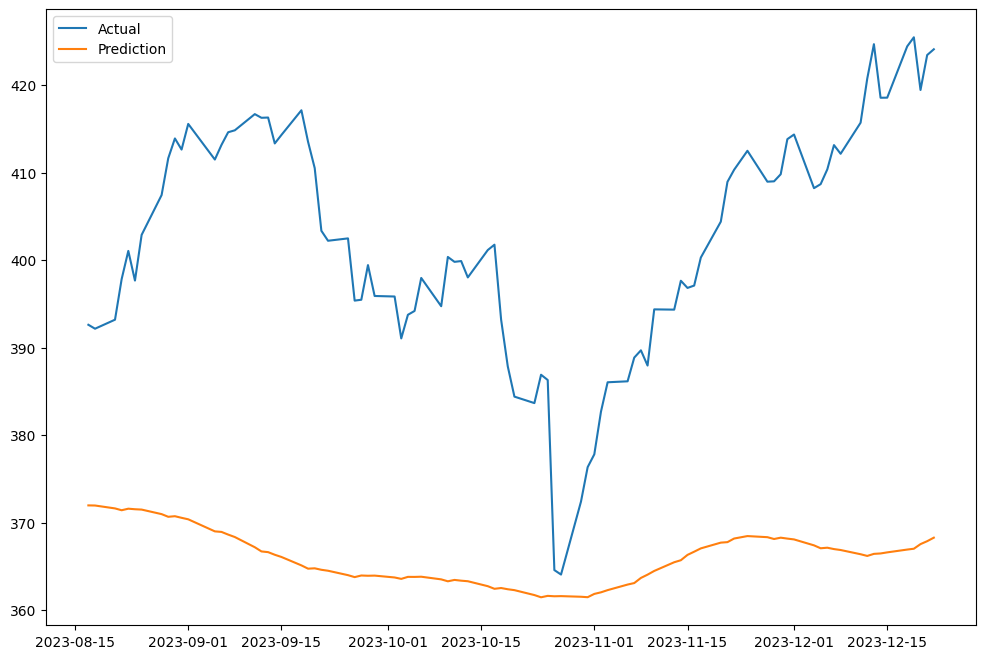

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))

pred = predictions[predictions['ds'].isin(unknown_data['ds'])] # The model will only go through dates that occur in our unknown data.

plt.plot(pd.to_datetime(unknown_data['ds']), unknown_data['y'], label="Actual")
plt.plot(pd.to_datetime(unknown_data['ds']), pred['yhat'], label="Prediction")

plt.legend()

## Key Observations:

- The predictions are not quite correct, the predictions generated by Prophet deviates from the actual values, consistently underestimating the stock prices.

- By omitting the last 90 day data we obtained valuable insights into the model's behavior under constrained data scenarios.

- Future improvements may involve refining the model parameters, incorporating additional relevant features, or exploring alternative forecasting techniques that may better handle abrupt market changes.

- In conclusion, while Prophet demonstrates forecasting capabilities with historical data, users should remain cautious when deploying the model in situations where recent data is limited or subject to significant fluctuations.
- Continuous refinement and adaptation of predictive models are crucial for enhancing their robustness and reliability in dynamic financial environments.